In [ ]:
Assignment1 FindAdWithBestCTR

YanXuan NUID001563047

In [ ]:
Step1. Create the Bandit model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pdb import set_trace

stationary=True
class Bandit():
  def __init__(self, arm_count):
    """
    Multi-armed bandit with rewards 1 or 0.
    
    At initialization, multiple arms are created. The probability of each arm
    returning reward 1 if pulled is sampled from Bernouilli(p), where p randomly
    chosen from Uniform(0,1) at initialization
    """
    self.arm_count = arm_count
    self.generate_thetas()
    self.timestep = 0
    global stationary
    self.stationary=stationary
    
  def generate_thetas(self):
    self.thetas = np.random.uniform(0,1,self.arm_count)
  
  def get_reward_regret(self, arm):
    """ Returns random reward for arm action. Assumes actions are 0-indexed
    Args:
      arm is an int
    """
    self.timestep += 1
    if (self.stationary==False) and (self.timestep%100 == 0) :
      self.generate_thetas()
    # Simulate bernouilli sampling
    sim = np.random.uniform(0,1,self.arm_count)
    rewards = (sim<self.thetas).astype(int)
    reward = rewards[arm]
    regret = self.thetas.max() - self.thetas[arm]
    
    return reward, regret

In [ ]:
Step2. Algorithms

In [ ]:
(1) Thompson Sampling

In [2]:
class BetaAlgo():
  """
  The algos try to learn which Bandit arm is the best to maximize reward.
  
  It does this by modelling the distribution of the Bandit arms with a Beta, 
  assuming the true probability of success of an arm is Bernouilli distributed.
  """
  def __init__(self, bandit):
    """
    Args:
      bandit: the bandit class the algo is trying to model
    """
    self.bandit = bandit
    self.arm_count = bandit.arm_count
    self.alpha = np.ones(self.arm_count)
    self.beta = np.ones(self.arm_count)
  
  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret
  
  def _update_params(self, arm, reward):
    self.alpha[arm] += reward
    self.beta[arm] += 1 - reward

class BernGreedy(BetaAlgo):
  def __init__(self, bandit):
    super().__init__(bandit)
  
  @staticmethod
  def name():
    return 'beta-greedy'
   
  def get_action(self):
    """ Bernouilli parameters are the expected values of the beta"""
    theta = self.alpha / (self.alpha + self.beta)
    return theta.argmax()
  
class BernThompson(BetaAlgo):
  def __init__(self, bandit):
    super().__init__(bandit)

  @staticmethod
  def name():
    return 'thompson'
  
  def get_action(self):
    """ Bernouilli parameters are sampled from the beta"""
    theta = np.random.beta(self.alpha, self.beta)
    return theta.argmax()

In [ ]:
(2) E-greedy

In [3]:
epsilon = 0.1
class EpsilonGreedy():
  """
  Epsilon Greedy with incremental update.
  Based on Sutton and Barto pseudo-code, page. 24
  """
  def __init__(self, bandit,epsilon=0.1):
#     global epsilon
    self.epsilon = epsilon
    self.bandit = bandit
    self.arm_count = bandit.arm_count
    self.Q = np.zeros(self.arm_count) # q-value of actions
    self.N = np.zeros(self.arm_count) # action count
  
  @staticmethod
  def name():
    return 'epsilon-greedy'
  
  def get_action(self):
    if np.random.uniform(0,1) > self.epsilon:
      action = self.Q.argmax()
    else:
      action = np.random.randint(0, self.arm_count)
    return action
  
  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret
  
  def _update_params(self, arm, reward):
    self.N[arm] += 1 # increment action count
    self.Q[arm] += 1/self.N[arm] * (reward - self.Q[arm]) # inc. update rule

In [ ]:
(3) UCB

In [4]:
ucb_c = 2
class UCB():
  """
  Epsilon Greedy with incremental update.
  Based on Sutton and Barto pseudo-code, page. 24
  """
  def __init__(self, bandit,ucb_c=2):
#     global ucb_c
    self.ucb_c = ucb_c
    self.bandit = bandit
    self.arm_count = bandit.arm_count
    self.Q = np.zeros(self.arm_count) # q-value of actions
    self.N = np.zeros(self.arm_count) + 0.0001 # action count
    self.timestep = 1
  
  @staticmethod
  def name():
    return 'ucb'
  
  def get_action(self):
    ln_timestep = np.log(np.full(self.arm_count, self.timestep))
    confidence = self.ucb_c * np.sqrt(ln_timestep/self.N)
    action = np.argmax(self.Q + confidence)
    self.timestep += 1
    return action
  
  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret
  
  def _update_params(self, arm, reward):
    self.N[arm] += 1 # increment action count
    self.Q[arm] += 1/self.N[arm] * (reward - self.Q[arm]) # inc. update rule

In [ ]:
(4) Random Sampling

In [5]:
class RandomSampling():
    def __init__(self, bandit, RS_scale=0.1):
        self.RS_scale = RS_scale
        self.bandit = bandit
        self.arm_count = bandit.arm_count

    def name():
        return 'Random Smpling'

    def get_action(self):
        action = np.random.randint(0, self.arm_count)
        return action

    def get_reward_regret(self, arm):
        reward, regret = self.bandit.get_reward_regret(arm)
        self._update_params(arm, reward)
        return reward, regret
    
    def _update_params(self, arm, reward):
        return

In [ ]:
Step3. Create helper functions

In [ ]:
(1) Helper functions for optimzing parameters of a single Algorithm

In [6]:
def plot_data(y):
    """ y is a 1D vector """
    x = np.arange(y.size)
    _ = plt.plot(x, y, 'o')

def plot_data_single(data, names):
    """ data, names are lists of vectors """
    x = np.arange(data[0].size)
    for i, y in enumerate(data):
        plt.plot(x, y, 'o', markersize=2, label=names[i])
    plt.legend(loc='upper right', prop={'size': 16}, numpoints=10)
    plt.show()

def simulate_single(simulations, timesteps, arm_count, Algorithm, para):
    """ Simulates the algorithm over 'simulations' epochs """
    sum_regrets = np.zeros(timesteps)
    for e in range(simulations):
        bandit = Bandit(arm_count)
        algo = Algorithm(bandit,para)
        regrets = np.zeros(timesteps)
        for i in range(timesteps):
            action = algo.get_action()
            reward, regret = algo.get_reward_regret(action)
            regrets[i] = regret
        sum_regrets += regrets  
    mean_regrets = sum_regrets / simulations
    return mean_regrets

def experiment_single(paras,algo,arm_count=10,timesteps=1000, simulations=1000):
    regrets = []
    for i in paras:
        regrets.append(simulate_single(simulations, timesteps, arm_count, algo,i))
    
    plot_data_single(regrets,paras)

In [ ]:
(2) Helper functions for comparing the performance of multiple algorithms

In [7]:
def plot_data(y):
  """ y is a 1D vector """
  x = np.arange(y.size)
  _ = plt.plot(x, y, 'o')
  
def multi_plot_data(data, names):
  """ data, names are lists of vectors """
  x = np.arange(data[0].size)
  for i, y in enumerate(data):
    plt.plot(x, y, 'o', markersize=2, label=names[i])
  plt.legend(loc='upper right', prop={'size': 16}, numpoints=10)
  plt.show()
  
def simulate(simulations, timesteps, arm_count, Algorithm):
  """ Simulates the algorithm over 'simulations' epochs """
  sum_regrets = np.zeros(timesteps)
  for e in range(simulations):
    bandit = Bandit(arm_count)
    algo = Algorithm(bandit)
    regrets = np.zeros(timesteps)
    for i in range(timesteps):
      action = algo.get_action()
      reward, regret = algo.get_reward_regret(action)
      regrets[i] = regret
    sum_regrets += regrets  
  mean_regrets = sum_regrets / simulations
  return mean_regrets

def experiment(arm_count, timesteps=1000, simulations=1000):
  """ 
  Standard setup across all experiments 
  Args:
    timesteps: (int) how many steps for the algo to learn the bandit
    simulations: (int) number of epochs
  """
  algos = [EpsilonGreedy, UCB, BernThompson, RandomSampling]
  regrets = []
  names = []
  for algo in algos:
    regrets.append(simulate(simulations, timesteps, arm_count, algo))
    names.append(algo.name())
  multi_plot_data(regrets, names)

In [ ]:
Step4. Answer the following questions

In [ ]:
Which hyperparameters are important for Thompson Sampling, e-greedy, UBC, and random sampling? Show that they are important (15 Points) 

Answer:
For Thompson Sampling uses prior beta distributions, it doesn't need hyperparameters.

Then in order to optmize, we need to make the arm_count an unchangeable number. I set it equals 10 in the helper function. 

For E-Greedy, epsilon is important. Showed in the following graph # Change epsilon in E-Greedy
Epsilon determines the frequency of exploration and exploitation for the agent, which is very important. 
Less explorations may offer less information to the agent, but too many explorations would cost too much time.

For UCB, ucb_cs is important. Showed in the following graph # Change ucb_c in UCB
The larger the value of ucb_cs, the longer the curve will take to stabilize and the more time will be wasted. 
Lowering the value of ucb_cs, that is, lowering the agent's "premium" for increasing uncertainty, the faster the convergence.

For random sampling, no hyperparameters can change the result, 
for everytime, this algorithm doesn't remember the previous actions, and choose randomly, which means its average is around same number.
Tried to change its RS_scale parameter, while no effect. Showed in the following graph # Change RS_scales in RandomSampling

In [49]:
#Define original parameters
epsilons = 0.1
ucb_c = 2
RS_scale = 0.1
stationary=True

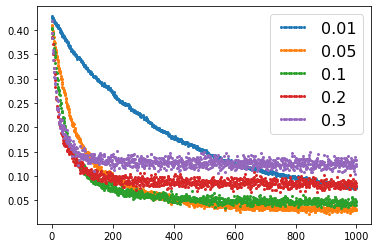

In [38]:
# Change epsilon in E-Greedy
epsilons = [0.01, 0.05, 0.1, 0.2, 0.3]
experiment_single(epsilons,EpsilonGreedy)

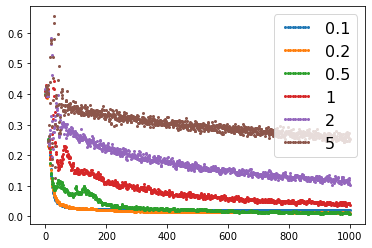

In [50]:
# Change ucb_c in UCB
ucb_cs = [0.1, 0.2, 0.5, 1, 2, 5]
experiment_single(ucb_cs,UCB)

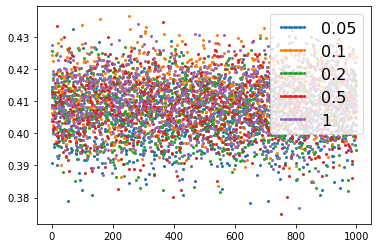

In [17]:
# Change RS_scales in RandomSampling
RS_scales = [0.05, 0.1, 0.2, 0.5, 1]
experiment_single(RS_scales,RandomSampling)

In [ ]:
How does the action space affect Thompson Sampling, e-greedy, UBC, and random sampling? Show why. (15 Points) 

Answer:
When action space, which is parameter arm_count, increases, each algorithm costs more time to converge.

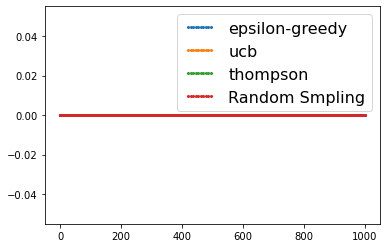

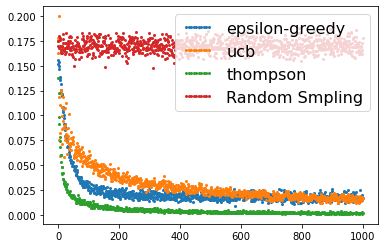

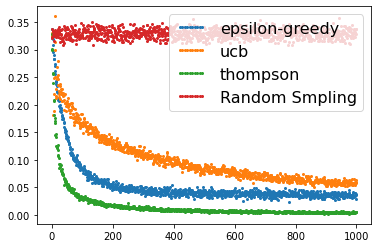

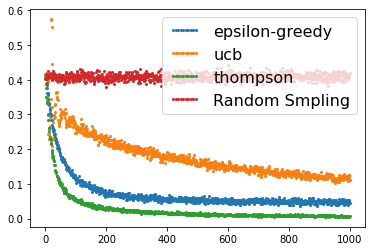

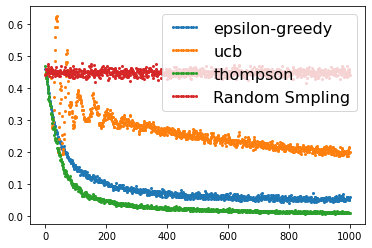

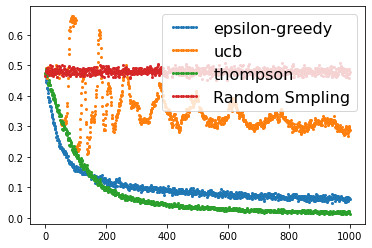

In [46]:
arm_count = [1,2,5,10,20,50] 
epsilon = 0.1
ucb_c = 2
RS_scale = 0.1
stationary=True

for i in arm_count:
    experiment(i)

In [ ]:
How does stationary affect Thompson Sampling, e-greedy, UBC, and random sampling? Show why. (15 Points) 

Answer:
First the fixed variables are as follows. If the environment is non-stationary, 
it can be seen that depending on the settings of the initial parameters, there will be resampled regret jumps every 100 steps. 
Thompson sampling
The Thompson Sampling algorithm converges the second fastest, and the regret value is constantly decreasing, 
but it needs to re-converge at each round of changes, and the convergence performance is getting slower and slower, 
and the convergence effect is getting worse and worse.
E-greed
The regret value of E-greed decreases relatively slower than Thompson Sampling, and the convergence perfoems not fast enough.
However, with the arm_count grows large enough, it may works faster than other algorithms.
UCB
The convergence performance of the UCB algorithm is the best, which shows that it is most suitable for non-stationary environments, 
and it also shows that it is a more suitable algorithm for "exploration" in the "exploration-exploition" process.
Random Sampling
With the increase of arm_count, the convergence speed of Random Sampling is always around the same number, 
for it make choices randomly everytime and don't remember previous actions.

The results are showed in graph # Simulation for non-stationary

In [47]:
# Still parameters
epsilon = 0.1
ucb_c = 2
RS_scale = 0.1

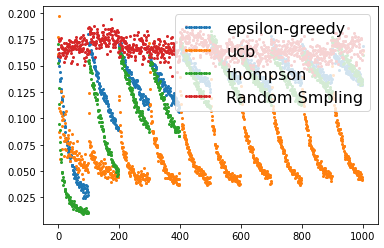

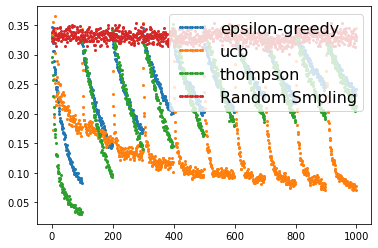

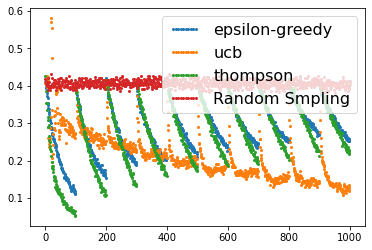

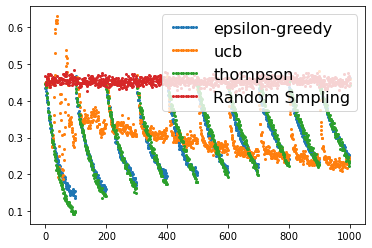

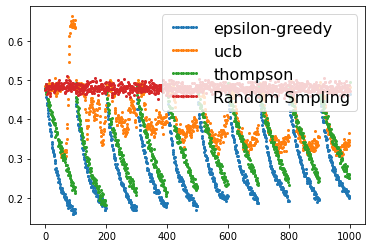

In [48]:
# Simulation for non-stationary
arm_count = [2,5,10,20,50]
stationary=False
for i in arm_count:
    experiment(i)

In [ ]:
When do Thompson Sampling, e-greedy, UBC, and random sampling stop exploring? 
Explain why. Explain the exploration-exploitation tradeoff (15 Points) 

Answer:
None of them stop exploring.
For Thompson Sampling, it's been exploring, and looking for the beta distribution that maximizes returns. 
For E-greedy, exploration doesn't stop until the simulation stops, and neither does UCB. 
For random sampling, since each sampling is random, it also does not stop exploring. 
Because the exploration coefficient can be infinitely close to 0 but not equal to 0, the further you explore, 
the smaller the "desire" of exploration, and the smaller the proportion, but it will not stop.

In [ ]:
How long do Thompson Sampling, e-greedy, UBC, and random sampling remember the past actions? Explain your answer. (10 Points) 

Answer:
Thompson Sampling, e-greedy and UCB algorithms are all able to remember past actions. Random sampling does not remember past actions.
Thompson Sampling requires beta distributions of action generation, so past actions are remembered.

E-greedy also remembers past actions, since it also needs the beta distribution of action generation 
to choose the next optimal action that will get the highest reward. 

UCB also remembers past actions, which is similar to E-greedy in that 
it selects the optimal action by calculating the uncertainty of the action.

Random sampling doesn't remember past actions because it's completely random, 
it just randomly chooses actions and doesn't take advantage of previous actions.

In [ ]:
Thompson Sampling with non-Beta distribution (5 Points) 
Modify the Thompson Sampling to run with a different distribution (e.g. Parteo, Normal, etc)

In [8]:
class ThompsonNormal():
    def __init__(self, bandit):
        self.bandit = bandit
        self.arm_count = bandit.arm_count
        self.record = [] # N*M ndarray, to record the each round result
        self.mean = np.ones(self.arm_count)
        self.var = np.zeros(self.arm_count)
        for i in range(0,self.arm_count):
            self.record.append([1]) # initialize records
    def get_reward_regret(self, arm):
        reward, regret = self.bandit.get_reward_regret(arm)
        self._update_params(arm, reward)
        return reward, regret

    def _update_params(self, arm, reward):
        self.record[arm] = np.append(self.record[arm],reward) 
        self.mean[arm] = self.record[arm].mean() 
        self.var[arm] = self.record[arm].var()

    def name():
        return 'Thompson Normal'

    def get_action(self):
        theta = np.random.normal(self.mean, self.var) # normal distribution
        return theta.argmax()

In [9]:
def ThompsonDerby(arm_count, timesteps=1000, simulations=1000):
    algos = [BernThompson, ThompsonNormal]
    regrets = []
    names = []
    for algo in algos:
        regrets.append(simulate(simulations, timesteps, arm_count, algo))
        names.append(algo.name())
    multi_plot_data(regrets, names)

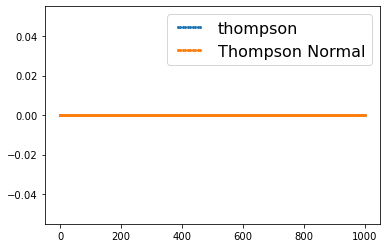

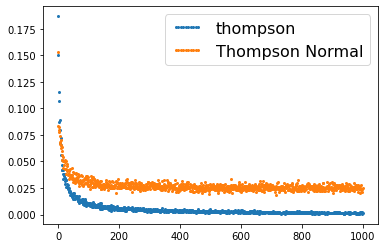

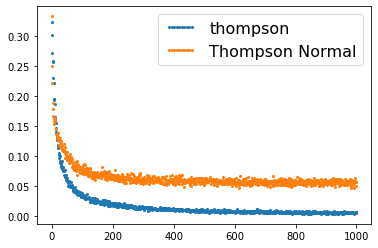

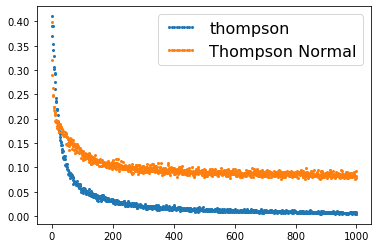

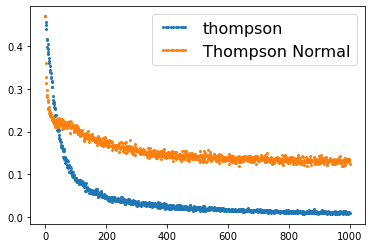

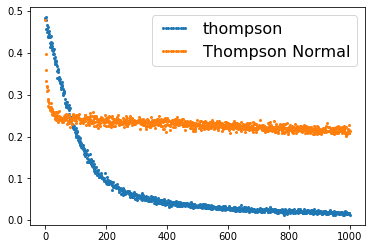

In [10]:
arm_count = [1,2,5,10,20,50] 

stationary=True
for i in arm_count:
    ThompsonDerby(i)

In [ ]:
What code is yours and what have you adapted? (10 Points)

Answer:
Added parameters to original Thompson Sampling, e-greedy and UCB algorithms
Random Sampling
Helper functions for optimzing parameters of a single Algorithm
Codes in Step4. Answer the following questions, except ThompsonNormal

In [ ]:
Reference

[1]: Andre Cianflone-Thompson sampling. URL:https://github.com/andrecianflone/thompson/blob/master/thompson.ipynb
[2]: The Multi-Armed Bandit Problem and Its Solutions. URL:https://lilianweng.github.io/posts/2018-01-23-multi-armed-bandit/
[3]: Reinforcement Learning - Thompson Sampling & the Multi-Armed Bandit Problem 
     URL:https://colab.research.google.com/drive/1gdR7k7jtSRqYnPNHcbAKdIjGRjQXpfnA
[4]: Russo, Daniel, Benjamin Van Roy, etc. "A Tutorial on Thompson Sampling." arXiv preprint arXiv:1707.02038 (2017).

In [ ]:
Did I explain my code clearly? (10 Points) Your code review score will be scaled to a range of 0 to 10 and be used for this score.
Yes

Did I explain my licensing clearly? (5 Points) Failure to cite a clear license will result in a zero for this section.
Yes